In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import fastcluster
from sklearn.metrics.pairwise import pairwise_distances
import seaborn as sns
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc

from ete3 import NCBITaxa, Tree, ProfileFace, AttrFace, TreeStyle, BarChartFace
ncbi = NCBITaxa()

# Plot the NCBI classification tree from file

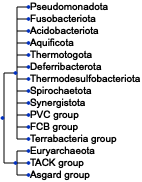

In [2]:
ProkaryoticOrders = Tree("../../Data/input/ProkaryotTree.nw", format=9)# made using orthofinder, NCBI ID's are slightly different to the ones from the strains in EggNOG so that's corrected in the .nw file.

ts = TreeStyle()
ts.draw_guiding_lines = True
ts.show_leaf_name = True
ts.scale =  10
ts.show_scale = False
ProkaryoticOrders.swap_children()


ProkaryoticOrders.render("%%inline", tree_style=ts,dpi=100)

In [3]:
order = [1224,32066,57723,200783,200918,200930,200940,203691,508458,1783257,1783270,1783272,28890,1783275,1935183]

# Load the OG DataFrame

In [4]:
Root_OG_Counts = pd.read_pickle("../../AllOFOG&eOGCounts.pkl")
Root_OG_Counts.head()

,UP000070043,UP000070149,UP000070599,UP000185561,UP000186063,UP000186209,UP000186239,UP000186851,UP000228988,UP000245584,...,999415,999419,999423,999425,999541,999547,999549,999550,999611,999630
eOG,,,,,,,,,,,,,,,,,,,,,
28H50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28H51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28H52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28H53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28H54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Open the list of clusters of orthologous groups of interest 

In [5]:
COGsOI = pd.read_csv("../../Data/input/AllWLPGenes.csv", sep =";", comment = "#", header = 0).iloc[:,[0,1,2,7,8]]
COGsOI = COGsOI.loc[COGsOI.Used == True, ["Category","Group","GeneName","COG"]]
COGsOI

,Category,Group,GeneName,COG
0,Metabolic,THMPT,FmdC,COG2218
1,Metabolic,THMPT,Ftr,COG2037
2,Metabolic,THMPT,Mch,COG3252
3,Metabolic,THMPT,Mtd,COG1927
4,Metabolic,THMPT,Hmd,COG4007
...,...,...,...,...
77,Ion-translocating,ECH,EhbD/MbhD,COG1563
78,Ion-translocating,ECH,EhbE/MbhG,COG1006
79,Ion-translocating,ECH,EhbH/I/MbhE/F,COG2111
80,Ion-translocating,ECH,EhbL/MbhN,COG1143


In [6]:
Root_COGsOI_Counts = Root_OG_Counts.loc[COGsOI.COG]

# By Genus

In [7]:
Taxonomy = pd.DataFrame(index = Root_COGsOI_Counts.columns)
Taxonomy["Kingdom"] = "NaN"
Taxonomy["Order"] = "NaN"

for ID in Taxonomy.index:
    if ID.startswith("UP"):
        Taxonomy.Kingdom[ID] = 2157
        Taxonomy.Order[ID] = 1935183
    else: 
        Taxonomy.Kingdom[ID] = ncbi.get_lineage(ID)[2]
        Taxonomy.Order[ID] = ncbi.get_lineage(ID)[3]

#Drop Eukarya
Taxonomy = pd.DataFrame(Taxonomy[~Taxonomy.Kingdom.isin([2759])])

#Drop incertae sedis orders
Taxonomy = pd.DataFrame(Taxonomy[~Taxonomy.Order.isin([2323,49928])])
             
SpeciesCount = Taxonomy.groupby("Order").size()
SpeciesCount

/Users/phivri/Applications/mambaforge/envs/PhyloETE/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1046724 was translated into 2739064
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/phivri/Applications/mambaforge/envs/PhyloETE/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1104325 was translated into 1158600
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/phivri/Applications/mambaforge/envs/PhyloETE/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1118055 was translated into 33037
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/phivri/Applications/mambaforge/envs/PhyloETE/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1121105 was translated into 1255705
  warnings.warn("taxid %s was translated into %s" %(taxi

/Users/phivri/Applications/mambaforge/envs/PhyloETE/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 265729 was translated into 246786
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/phivri/Applications/mambaforge/envs/PhyloETE/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 319236 was translated into 323273
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/phivri/Applications/mambaforge/envs/PhyloETE/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 335659 was translated into 1404864
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/phivri/Applications/mambaforge/envs/PhyloETE/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 35720 was translated into 2587410
  warnings.warn("taxid %s was translated into %s" %(taxid, me

/Users/phivri/Applications/mambaforge/envs/PhyloETE/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 981223 was translated into 470
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


Order
1224       1555
28890       120
29547        80
32066        30
40117         4
57723        16
68297         2
200783       16
200918       17
200930        6
200938        2
200940       78
203691       48
508458       15
1783257      52
1783270     428
1783272    2060
1783275      41
1802340       1
1930617       1
1935183      68
2138240       2
2283796       7
2498710       1
2818505      15
3018035       8
dtype: int64

# Prune tree to drop orders with fewer than 5 members

In [8]:
RootOGs = Root_COGsOI_Counts > 0
RootOGs.head()

,UP000070043,UP000070149,UP000070599,UP000185561,UP000186063,UP000186209,UP000186239,UP000186851,UP000228988,UP000245584,...,999415,999419,999423,999425,999541,999547,999549,999550,999611,999630
eOG,,,,,,,,,,,,,,,,,,,,,
COG2218,True,True,True,True,False,False,False,True,False,False,...,False,False,False,False,False,True,True,False,True,False
COG2037,True,True,True,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
COG3252,True,True,True,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
COG1927,True,True,False,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
COG4007,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
data = RootOGs.T.merge(Taxonomy, how = "left", left_index=True, right_index=True).drop(columns = "Kingdom")#.groupby(["Group"])

#Group by Taxonomic order
data = data.groupby(data.iloc[:,-1]).sum()

#Convert to a percentage of species for each order
data = data.divide(SpeciesCount, axis=0).loc[order]

data.head()

/var/folders/qr/vm827mh53sd6708z2k3_tnnrz3fj08/T/ipykernel_52327/3003098859.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(data.iloc[:,-1]).sum()


,COG2218,COG2037,COG3252,COG1927,COG4007,COG2141,COG1962,COG4058,COG4054,COG4057,...,COG3260,COG3261,COG1863,COG2212,COG1320,COG1563,COG1006,COG2111,COG1143,COG0650
Order,,,,,,,,,,,,,,,,,,,,,
1224,0.180707,0.063023,0.061736,0.0,0.000000,0.754984,0.000643,0.0,0.0,0.0,...,0.158842,0.163344,0.542122,0.535691,0.536334,0.060450,0.542765,0.515756,0.876527,0.145981
32066,0.000000,0.000000,0.000000,0.0,0.000000,0.233333,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.700000,0.000000
57723,0.000000,0.000000,0.000000,0.0,0.000000,0.812500,0.000000,0.0,0.0,0.0,...,0.187500,0.187500,0.000000,0.000000,0.000000,0.000000,0.062500,0.062500,1.000000,0.187500
200783,0.000000,0.000000,0.000000,0.0,0.125000,0.000000,0.000000,0.0,0.0,0.0,...,0.562500,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000
200918,0.000000,0.000000,0.000000,0.0,0.058824,0.000000,0.000000,0.0,0.0,0.0,...,0.117647,0.117647,0.882353,0.764706,0.823529,0.941176,0.941176,0.941176,1.000000,0.764706


plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.left'] = False

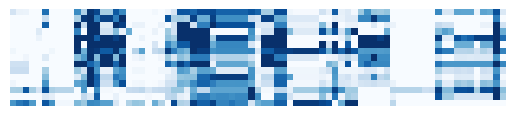

In [10]:
plt.imshow(data[COGsOI.COG], cmap='Blues', interpolation='nearest')
#plt.savefig("../../Data/output/SpeciesCountHeatmap.png", dpi=300)
plt.tick_params(left = False, bottom = False)
plt.axis('off')
plt.show()

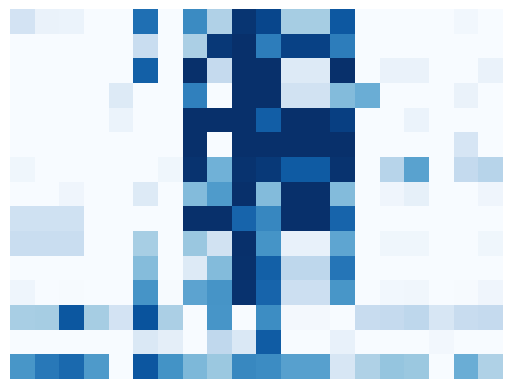

In [11]:
plt.imshow(data[COGsOI[COGsOI.Category == "Metabolic"].COG], cmap='Blues', interpolation='nearest')
plt.axis('off')
plt.show()

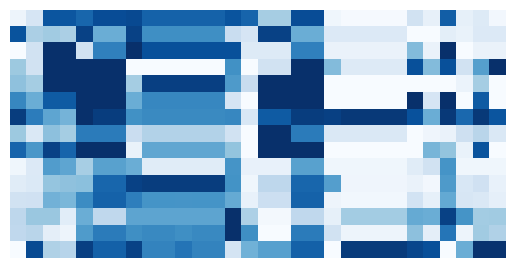

In [12]:
plt.imshow(data[COGsOI[COGsOI.Category == "Bifurcating"].COG], cmap='Blues', interpolation='nearest')
plt.axis('off')
plt.show()

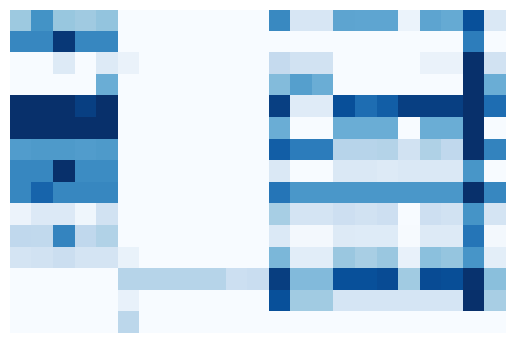

In [13]:
plt.imshow(data[COGsOI[COGsOI.Category == "Ion-translocating"].COG], cmap='Blues', interpolation='nearest')
plt.axis('off')
#plt.colorbar()
plt.show()